## GloVe-LSTM Sentimental Analysis on Movie Review
build up and train the sentiment model

In [2]:
import json
import time
import os

import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

Using TensorFlow backend.


### Data Process
respectively train the *IMBb user data* and *Critics data*

In [2]:
# read the data from csv file
#data = pd.read_csv('content.csv', index_col= 0)
cr_data = pd.read_csv('critics_content.csv', index_col= 0)

In [1]:
## set up the exogenuous parameter
#max_sequence_length = 160 # for IMDb 
max_sequence_length = 40 # for Rotten Tomato Criitics 
max_features = 20000

#### Tokenization

In [4]:
cr_tokenizer = Tokenizer(num_words=max_features,
                         split=' ',
                         oov_token='<unw>')

cr_tokenizer.fit_on_texts(cr_data['content'].values)

In [257]:
tokenizer = Tokenizer(num_words=max_features,
                      split=' ',
                      oov_token='<unw>')

tokenizer.fit_on_texts(data['content'].values)

In [5]:
# token
word_index = cr_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#word_wiki = list(word_index.keys())

Found 39829 unique tokens.


In [6]:
# derive X value
X = cr_tokenizer.texts_to_sequences(cr_data['content'].values)

# zero padding
X = pad_sequences(X, maxlen= max_sequence_length)

# multi-class dummy variable for y
y = pd.get_dummies(cr_data['sentiment']).values

In [7]:
# lets keep a couple of thousand samples back as a test set
X_tot, X_test, y_tot, y_test = train_test_split(X, y, test_size=0.1)

X_train, X_val, y_train, y_val = train_test_split(X_tot, y_tot, test_size=0.1)


In [32]:
len(X_train), len(X_val), len(X_test)

(54974, 6109, 6788)

*flexible sequence length with batch*

[source](https://datascience.stackexchange.com/questions/26366/training-an-rnn-with-examples-of-different-lengths-in-keras)



* Glove Embeddings:

    [GloVe](https://nlp.stanford.edu/projects/glove/) stands for "Global Vectors for Word Representation". GloVe is an unsupervised learning algorithm initialized from Stanford NLP Lab for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. In a nutshell, it is a popular embedding technique based on factorizing a matrix of word co-occurence statistics.
    1. convert all text samples in the dataset into sequences of word indices. A "word index" would simply be an integer ID for the word. 
    2. prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.
    3. load this embedding matrix into a Keras Embedding layer, set to be frozen (its weights, the embedding vectors, will not be updated during training).
    
In detail, used the the Common Crawl-840B GloVe model.

In [8]:
# set up the source path
EMBEDDING_FILE_PATH = '../../glove.840B.300d.txt'

In [9]:
# Indexing word vectors
embeddings_index = {}
f = open(EMBEDDING_FILE_PATH)
count = 0
for line in tqdm(f):
    values = line.split()
    word = ''.join(values[0])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('load embedding complete')

2196018it [02:37, 13903.17it/s]

load embedding complete


In [10]:
embedding_dim = 300

# derive the num of words
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer find that word in w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # not exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

20001


### Bidirectional-LSTM model 

In [11]:
## Architecture
model = Sequential()

model.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))

model.add(BatchNormalization())
#model.add(Bidirectional(LSTM(300, dropout= 0.1, recurrent_dropout= 0.1, return_sequences=True,name='lstm1'),
#                             name='bi_lstm_1'))
model.add(Bidirectional(LSTM(150, dropout= 0.2, recurrent_dropout= 0.2, name='lstm_2'),
                        name='bi_lstm_2'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(units=3, activation='softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [12]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           6000300   
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 300)           1200      
_________________________________________________________________
bi_lstm_2 (Bidirectional)    (None, 300)               541200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total params: 6,544,803
Trainable params: 543,303
Non-trainable params: 6,001,500
____________________________________________________________

* F1 Metrics:

    compute [f1 score](https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2) for each epoch in Keras

In [13]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        y_logit, y_real = self.model.predict(self.validation_data[0]), self.validation_data[1]
        # transfer into integer 
        val_predict = list(map(np.argmax, y_logit))
        val_targ = list(map(np.argmax, y_real))
        
        _val_f1 = f1_score(val_targ, val_predict,  average='macro')
        _val_recall = recall_score(val_targ, val_predict,  average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        print("— val_f1: %f — val_precision: %f — val_recall: %f"%(_val_f1, _val_precision, _val_recall))
        return

F1 = Metrics()

* early stopping

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

STAMP = 'Bidirection-LSTM-GloVe-Critics'

early_stopping =EarlyStopping(monitor='val_loss', patience=4, verbose= 1)

bst_model_path = STAMP + '.h5'

model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True)

In [190]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67888 entries, 1 to 10
Data columns (total 6 columns):
content              67888 non-null object
date                 67888 non-null object
score                67888 non-null object
movie                67888 non-null object
word_length          67888 non-null int64
predict_sentiment    67888 non-null int64
dtypes: int64(2), object(4)
memory usage: 3.6+ MB


### Train the Model

* TensorBoard Monitor

[document](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)

In [15]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs/critics', **kwargs):
        # keep track of batch times
        self.val_log_dir = os.path.join(log_dir, 'validation')
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

    def set_model(self, model):
        if context.executing_eagerly():
            self.val_writer = tf.contrib.summary.create_file_writer(self.val_log_dir)
        else:
            self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)
        
    def _write_custom_summaries(self, step, logs=None):
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if 'val_' in k}
        if context.executing_eagerly():
            with self.val_writer.as_default(), tf.contrib.summary.always_record_summaries():
                for name, value in val_logs.items():
                    tf.contrib.summary.scalar(name, value.item(), step=step)
        else:
            for name, value in val_logs.items():
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.val_writer.add_summary(summary, step)
        self.val_writer.flush()

        logs = {k: v for k, v in logs.items() if not 'val_' in k}
        super(TrainValTensorBoard, self)._write_custom_summaries(step, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
tensor_board = TrainValTensorBoard(write_graph= False)

print(tensor_board.log_dir)

./logs/critics/training


* Model Training

In [16]:
# hyperparameter 
batch_size = 256
epoch_num = 30

In [17]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epoch_num,
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks = [early_stopping, model_checkpoint])
bst_val_score = min(history.history['val_loss'])

Train on 54974 samples, validate on 6109 samples
Epoch 1/30
54974/54974 [==============================] - 113s 2ms/step - loss: 1.0742 - acc: 0.5006 - val_loss: 0.8927 - val_acc: 0.5868












### Evaluation

* best model

**epoch 7**

In [18]:
best_model = model_checkpoint.model

In [19]:
# predict the value with test data
y_pred = best_model.predict(X_test)

In [20]:
# Prediction from on-hot to number
y_pred_lab = np.argmax(y_pred, axis = 1)
y_test_lab = np.argmax(y_test, axis = 1)

In [21]:
# Accuracy
accuracy_score(y_pred_lab, y_test_lab)

0.6216853270477313

In [22]:
# F1 Score
f1_score(y_pred_lab, y_test_lab, average= 'macro')

0.6009618846727958

In [23]:
# Precision
precision_score(y_pred_lab, y_test_lab, average= 'macro')

0.6049175424811349

In [24]:
# Recall
recall_score(y_pred_lab, y_test_lab, average= 'macro')

0.6044839724236363

* Comparison Random Predictor

In [320]:
# random predicted classification
y_random_pred = np.random.randint(0,5, size = len(y_pred_lab))

In [323]:
# F1 Score
print('F1 Score:')
print(f1_score(y_random_pred, y_test_lab, average= 'macro'), '\n')

print('Precision:')
print(precision_score(y_random_pred, y_test_lab, average= 'macro'), '\n')

print('Recall:')
print(precision_score(y_random_pred, y_test_lab, average= 'macro'))

F1 Score:
0.20124842248182712 

Precision:
0.2049823741655011 

Recall:
0.2049823741655011


In [25]:
FIG_SIZE = (12,8)

In [158]:
def eval_plot(history_record, eval_type = 'acc', figsize = FIG_SIZE, fsize = 20):
    plt.figure(figsize = figsize)
    plt.plot(history.history[eval_type])
    plt.plot(history.history['val_' + eval_type])
    plt.title('model evaluation of {}'.format(eval_type), fontsize = fsize)
    plt.ylabel(eval_type)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left', fontsize = 18)
    plt.show()
    
    return 

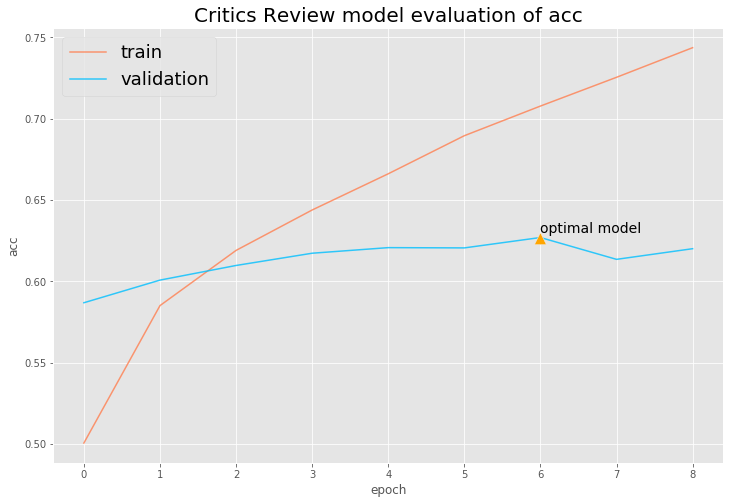

In [197]:
eval_type = 'acc'

plt.figure(figsize = FIG_SIZE)
plt.plot(history.history[eval_type], color = 'coral', alpha = 0.8)
plt.plot(history.history['val_' + eval_type], color  = 'deepskyblue', alpha = 0.8)
plt.title('Critics Review model evaluation of {}'.format(eval_type), fontsize = 20)
plt.ylabel(eval_type)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left', fontsize = 18)
plt.annotate('optimal model',
             (6, 0.63),
             fontsize = 14,
             arrowprops=dict(facecolor= 'orange', shrink= 0.05))
plt.show()

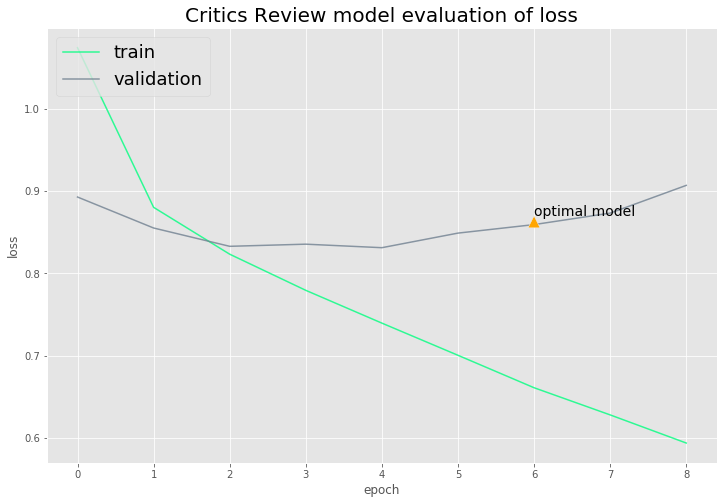

In [40]:
eval_type = 'loss'

ax = plt.figure(figsize = FIG_SIZE)
plt.plot(history.history[eval_type], color = 'springgreen', alpha = 0.8)
plt.plot(history.history['val_' + eval_type], color  = 'slategray', alpha = 0.8)
plt.annotate('optimal model',
             (6, 0.87),
             fontsize = 14,
             arrowprops=dict(facecolor= 'orange', shrink= 0.05))
plt.title('Critics Review model evaluation of {}'.format(eval_type), fontsize = 20)
plt.ylabel(eval_type)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left', fontsize = 18)
plt.show()

### Sentiment Monitor

In [193]:
# load the total review df
df_review = pd.read_csv('critics_review.csv',
                        index_col= 0,
                        parse_dates= [3])

In [194]:
df_review.movie.nunique()

1860

In [43]:
# release info
df_movie_info = pd.read_csv('../general_movie.csv', index_col= 0)\
                [['name', 'Release_date']]

df_movie_info['Release_date'] = df_movie_info.Release_date.apply(pd.to_datetime)

# movie dictionary
mov_dict = dict(df_movie_info.values)

In [97]:
def map_encode(text_array, tokenizer = cr_tokenizer, max_len = max_sequence_length):
    '''
    func. to map the text array into integer sequence
    '''
    digital_arr = tokenizer.texts_to_sequences(text_array)
    
    return pad_sequences(digital_arr, maxlen= max_len)

int_cont = map_encode(df_review['content'])

def sentiment_output(num_comment, max_len = max_sequence_length):
    pred_logit = best_model.predict(num_comment.reshape(1, max_sequence_length))
    
    return np.argmax(pred_logit)

In [102]:
sentiment_pred = [sentiment_output(x) for x in tqdm(int_cont)]

100%|██████████| 67888/67888 [07:48<00:00, 144.97it/s]


In [103]:
df_review['predict_sentiment'] = sentiment_pred

In [104]:
df_review.head()

,content,date,score,movie,word_length,predict_sentiment
1,Rowling and Yates succeed at transporting you...,2016-11-12,6.0,Fantastic Beasts and Where to Find Them,17,2
2,Rowling and Yates have given us a terrificall...,2016-11-12,10.0,Fantastic Beasts and Where to Find Them,16,2
3,Who needs Harry Potter With Fantastic Beasts ...,2016-11-12,8.0,Fantastic Beasts and Where to Find Them,22,2
6,As a feat of world - building and character -...,2016-11-12,8.0,Fantastic Beasts and Where to Find Them,16,2
8,Diehard fans will likely adore it and its fam...,2016-11-12,7.0,Fantastic Beasts and Where to Find Them,27,2


In [135]:
# average into movie sentiment 
sentiment_movie = pd.DataFrame(df_review.groupby('movie')['predict_sentiment'].mean())
sentiment_movie.index.name = 'name'

In [161]:
sentiment_movie.rename(inplace = True,
                       columns = \
                       lambda x : \
                       'critics_sentiment' if x == 'Predicted Critics Sentiment' else x)

* concatenate with general film data

In [162]:
df_general = pd.read_csv('general_film.csv', index_col= 0)
df_general = df_general.join(sentiment_movie, on = 'name')
df_general.to_csv('data/general_film.csv')

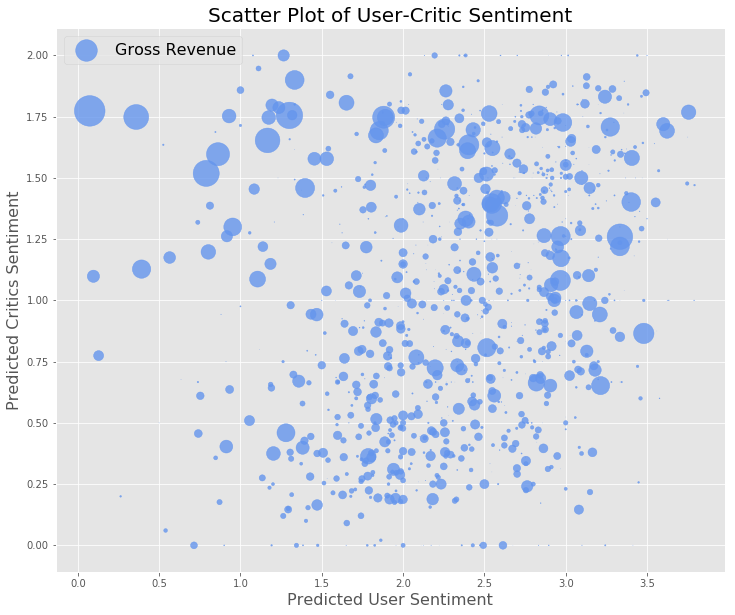

In [198]:
ax = df_general.plot(kind='scatter',
                     figsize = (12, 10),
                     color = 'cornflowerblue',
                     alpha = 0.8,
                     x='predicted_sentiment', y='critics_sentiment', s=df_general.Gross)

ax.set_title('Scatter Plot of User-Critic Sentiment', fontsize = 20)
ax.set_xlabel('Predicted User Sentiment', fontsize = 16)
ax.set_ylabel('Predicted Critics Sentiment', fontsize = 16)
ax.legend(['Gross Revenue'], loc =2, fontsize = 16)

further check the outlier

In [182]:
df_general[(df_general['predicted_sentiment'] <= 0.5) & \
           (df_general['critics_sentiment'] >= 1.5) & (df_general['rate'] >= 7)]

,name,certificate,description,genre,link,meta_score,rate,Budget,Open,Studio,...,Western,famous_director,famous_actor,Release_date,Release_Year,Release_Month,Release_Day,famous_studio,predicted_sentiment,critics_sentiment
42,Star Wars: The Last Jedi,PG-13,Rey develops her newly discovered abilities wi...,"Action, Adventure, Fantasy",https://www.imdb.com/title/tt2527336/?ref_=adv...,85.0,7.2,NaN,220009584.0,"Walt Disney Pictures,Lucasfilm,Ram Bergman Pro...",...,0,0.0,0.0,15-Dec-17,15.0,12.0,2017.0,1.0,0.358974,1.748768
160,Star Wars: The Force Awakens,PG-13,"Three decades after the Empire's defeat, a new...","Action, Adventure, Fantasy",https://www.imdb.com/title/tt2488496/?ref_=adv...,81.0,8.0,20.416667,247966675.0,"Lucasfilm,Bad Robot,Truenorth Productions",...,0,0.0,0.0,18-Dec-15,18.0,12.0,2015.0,0.0,0.073171,1.773684
